## Experiment-02
### Amirreza Fosoul and Bithiah Yuan

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
import string
import csv
import re
import time
spark = SparkSession.builder.appName('ex2').getOrCreate()

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.functions import split
import pyspark.sql.functions as f
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, StringType
from pyspark.sql.functions import desc

# Read user ratings into Dataframe
user_df = spark.read.option("delimiter", ";").csv('./users_libraries.txt')
#user_df = spark.read.option("delimiter", ";").csv('./example.txt')
user_df = user_df.select(col("_c0").alias("userID"), col("_c1").alias("paperID"))

user_pre = user_df

user_df = user_df.select("userID", f.split("paperID", ",").alias("papers"), f.explode(f.split("paperID", ",")).alias("paperID"))
user_df = user_df.drop("papers")

# Count the number of distinct users
numUsers = user_df.select("userID").distinct().count()

# Get a dataframe of the distinct papers
d_paper = user_df.select("paperID").distinct()

### Exercise 2. 1 (Advanced analysis)

In [19]:
# Count the number of distinct papers
numPapers = d_paper.count()

z = numUsers*numPapers

# Count the number of ratings
numRatings = user_df.count()

# Calculate the missing ratings in the rating matrix and
# calculate the sparsity of the rating matrix
sparsity = (z - numRatings)/z
print(sparsity)

0.9998305694442852


#### Users/Ratings rank-frequency distribution

In [13]:
# Count the number of papers each user rated
numRatings_user = user_df.groupBy('userID').count()

# Count the number of users w.r.t. to the number of ratings
users_ratings = numRatings_user.select(col('userID'), col("count").alias("library_size")).orderBy('count', ascending=False)
# Count the number of ratings w.r.t. the count of the number of users
users_ratings = users_ratings.groupBy('library_size').count().orderBy('library_size', ascending=False)
users_ratings = users_ratings.toPandas()

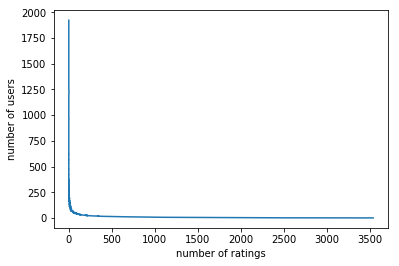

In [14]:
import matplotlib.pyplot as plt

num_ratings = users_ratings['count']
num_users = users_ratings['library_size']

plt.plot(num_ratings, num_users)
plt.xlabel('number of ratings')
plt.ylabel('number of users')
plt.show()

#### Papers/Ratings rank-frequency distribution

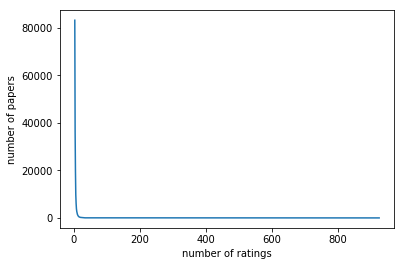

In [16]:
# Group the dataframe by the paperID and count the number of papers
papers_ratings = user_df.groupBy('paperID').count()
# Rename column count as paper_count
papers_ratings = papers_ratings.select(col("paperID"), col("count").alias("paper_count"))
# Count the number of ratings w.r.t. to the number of papers
papers_ratings = papers_ratings.groupBy('paper_count').count().orderBy('paper_count', ascending=False)
papers_ratings = papers_ratings.toPandas()

num_ratings = papers_ratings['paper_count']
num_papers = papers_ratings['count']

plt.plot(num_ratings, num_papers)
plt.xlabel('number of ratings')
plt.ylabel('number of papers')
plt.show()

Most of the papers have a small number of ratings. We noticed a long-tail so it follows the power-law. 

### Exercise 2. 2 Rating matrix preparation

In [3]:
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import concat, col, lit, size
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import IntegerType
sc = spark.sparkContext
import random

# Create a user hash map dataframe by adding a column with descending row numbers 
# to the pre-explode user dataframe
user_hash_map = user_pre.withColumn("user_idx", F.monotonically_increasing_id().cast(IntegerType()))

# Select the user indices and paperID
rating = user_hash_map.select('user_idx', 'paperID')

# Split the string if all paperIDs into individual paperIDs and cast the datatype to int
rating = rating.withColumn("papers", split(col("paperID"), ",\s*").cast(ArrayType(IntegerType())).alias("papers"))
# Drop the column with the string of paperIDs
rating = rating.drop("paperID")

# Add a column of 1's called ratings for the rated papers w.r.t to the user index
rating = rating.withColumn("rating", lit(1))

# Transform the distinct paperIDs dataframe to a list
paper_list = list(d_paper.select('paperID').toPandas()['paperID'])
# Map each distinct paper into int
paper_list = list(map(int, paper_list))

# Function to call in udf
def unrated(papers):
    # Transform the list of distinct papers and the list of rated papers of each user to a set
    # Substract the two sets to get the list of unrated papers for each user
    # Transform back to list
    unrated = list(set(paper_list) - set(papers))

    # Select n random papers from the unrated papers where n is the 
    # length of the rated papers list of each user
    unrated_papers = random.sample(unrated, len(papers))
            
    return unrated_papers


# udf to get a list of unrated papers with the length of rated papers for each user
get_unrated = udf(lambda x: unrated(x), ArrayType(IntegerType()))

# Add a new column of unrated papers for each user
rating = rating.withColumn("unrated", get_unrated(rating.papers))

# Create a dataframe with the rated papers and their ratings of 1's
rated_df = rating.select("user_idx", "papers", "rating")

# Create a dataframe with the unrated papers
unrated_df = rating.select("user_idx", col("unrated").alias("papers"))
# Add a column of ratings of 0's to the unrated papers
unrated_df = unrated_df.withColumn("rating", lit(0))

# Union the rated and unrated dataframes and order by the user indices
rating_matrix = rated_df.union(unrated_df).orderBy("user_idx")

# Explode the lists of paperIDs w.r.t. each user
rating_matrix = rating_matrix.select("user_idx", f.explode("papers").alias("paperID"), 'rating')

In [17]:
rating_matrix.where(rating_matrix.user_idx=="14").show()

+--------+--------+------+
|user_idx| paperID|rating|
+--------+--------+------+
|      14|  115945|     1|
|      14|11733005|     1|
|      14| 9045137|     1|
|      14| 3728173|     1|
|      14| 8310458|     1|
|      14| 3385639|     1|
|      14|  361707|     0|
|      14| 1371682|     0|
|      14| 3065830|     0|
|      14|10155007|     0|
|      14| 5376028|     0|
|      14| 5770898|     0|
+--------+--------+------+



In [3]:
rating_matrix.show()

+--------+-------+------+
|user_idx|paperID|rating|
+--------+-------+------+
|       0|3929762|     1|
|       0| 503574|     1|
|       0|5819422|     1|
|       0|4238883|     1|
|       0|5788061|     1|
|       0| 462949|     1|
|       0| 635215|     1|
|       0| 635216|     1|
|       0|4810441|     1|
|       0|3481823|     1|
|       0|4165233|     1|
|       0|3366480|     1|
|       0|5984302|     1|
|       0|4238942|     1|
|       0|5490453|     1|
|       0|4636156|     1|
|       0|5996865|     1|
|       0|4194836|     1|
|       0|5828780|     1|
|       0|4450195|     1|
+--------+-------+------+
only showing top 20 rows



### Exercise 2.3 (ALS algorithm)

In [4]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Get the user index corresponding to the given userID
user = user_hash_map.select('user_idx').where(user_hash_map.userID=="1eac022a97d683eace8815545ce3153f").show()                                                                                                          

+--------+
|user_idx|
+--------+
|      33|
+--------+



In [7]:
als = ALS(maxIter=5, userCol="user_idx", itemCol="paperID", ratingCol="rating", coldStartStrategy="drop")

model = als.fit(rating_matrix)

In [11]:
# Get top 10 recommendations
# Result [paperID, prediction]
userRecs = model.recommendForAllUsers(10)
userRecs.select('*').where(userRecs.user_idx=="33").show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_idx|recommendations                                                                                                                                                                                          |
+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|33      |[[418828,2.7784605], [10677634,2.743701], [1038496,2.685771], [2985762,2.5943809], [574,2.5866868], [2712544,2.567454], [522797,2.5550659], [7983526,2.5538464], [6628691,2.5516655], [7134684,2.551024]]|
+--------+------------------------------------------------------------------------------------------------------------------------------------------

### Exercise 2. 4 (Recommender System Evaluation)

In [5]:
(training, test) = rating_matrix.randomSplit([0.7, 0.3])

In [12]:
training_model = als.fit(training)

predictions = training_model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.5184298347587089


In [13]:
# Select the user indices and order the prediction column in descending order
window = Window.partitionBy(col("user_idx")).orderBy((col("prediction")).desc())

# Select all the columns and add a column of row numbers over each user and get the top 10 rows
p = predictions.select(col('*'), row_number().over(window).alias('row_number')).where(col('row_number') <= 10)

# Drop the rating and row_number column
p= p.drop('rating', 'row_number')

# Create a new column with the concatenation of the paperID and it's prediction
p = p.withColumn("paper_pred", f.concat(col("paperID"), lit(" "), col("prediction")))
# Drop paperID and prediction column
p = p.drop("paperID", "prediction")

# For each user index concatenate all his paperID predictions
p = p.groupby("user_idx").agg(f.concat_ws(", ", f.collect_list("paper_pred")).alias("Recommendations"))

# Show the top 10 recommendations for the given user
p.select('*').where(p.user_idx=="33").show(truncate=False)

+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_idx|Recommendations                                                                                                                                                                         |
+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|33      |833661 2.2837799, 6351182 2.0041034, 1926414 1.9341322, 484976 1.8524623, 531300 1.6097639, 4191871 1.5111355, 2348956 1.4977813, 8465912 1.4669486, 5915678 1.4315963, 388242 1.4122236|
+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+



### Exercise 2. 5 (Hyperparameter tuning)

We are using a reduced user_libraries file called "example.txt" due to the runtime. 

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

als = ALS(userCol="user_idx", itemCol="paperID", ratingCol="rating", coldStartStrategy="drop")

# Construct a grid of parameters to search over the list of ranks
param_grid = ParamGridBuilder().addGrid(als.rank,[10, 25, 50],).build()

# Measure the rmse to determine how well a fitted Model does on held-out test data
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",)

# Tune the parameter of ALS 
# numFolds = 3 generates 3 (training, test) dataset pairs
# each uses 2/3 of the data for training and 1/3 for testing. 
# then computes the average evaluation metric for the 3 Models produced 
# by fitting the Estimator on the 3 different (training, test) dataset pairs.
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,numFolds=3)

cv_model = crossval.fit(training)

In [7]:
# Get the best model
best_model = cv_model.bestModel
# Get the rank of the best model
best_model.rank

10

In [8]:
rmse = evaluator.evaluate(best_model.transform(test))
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.39693658391671854


In [13]:
als = ALS(maxIter = 15, rank = best_model.rank, userCol="user_idx", itemCol="paperID", ratingCol="rating", coldStartStrategy="drop")

training_model = als.fit(training)

predictions = training_model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.3912164198495297


In [10]:
als = ALS(maxIter = 20, rank = best_model.rank, userCol="user_idx", itemCol="paperID", ratingCol="rating", coldStartStrategy="drop")

training_model = als.fit(training)

predictions = training_model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.38993338263740007


In [11]:
als = ALS(maxIter = 25, rank = best_model.rank, userCol="user_idx", itemCol="paperID", ratingCol="rating", coldStartStrategy="drop")

training_model = als.fit(training)

predictions = training_model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.3744957957540127


When we increased the maxIter, the rmse decreases slightly.